# 1. EDA

### The preprocessing of the Tiny LISA traffic sign image dataset is performed to train a Convolutional Neural Network (CNN).

- **Reading Annotations**: Image and class information is read from a CSV file, with a class mapping an index to each unique class name.
   
- **Image Augmentation**: Augmentation techniques like rescaling, shearing, zooming, flipping, and brightness adjustment are applied to enhance the training dataset.

- **Loading and Resizing Images**: Images are loaded from the specified path and resized to a common size.

- **Applying Augmentations**: Multiple augmented images are generated from each original image.

- **Label Transformation**: Class labels are one-hot encoded for multi-class classification.

- **Conversion to Numpy Arrays**: Augmented images and class labels are converted into numpy arrays for model input.

In [12]:
import sys
print(sys.executable)

/Users/argishtiovsepyan/anaconda3/bin/python


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from typing import Tuple, List, Dict
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [14]:
# Configuration
IMAGE_SIZE = (224, 224)
NUM_AUG = 3
CSV_PATH = '../data/original_data/annotations.csv'
DATA_DIR = '../data/original_data'
PROCESSED_DATA_DIR = '../data/preproc_data'
RANDOM_STATE = 42

In [15]:
def load_annotations(csv_path: str) -> pd.DataFrame:
    """
    Load annotations from a CSV file.

    Args:
        csv_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: DataFrame of annotations.

    Raises:
        FileNotFoundError: If the CSV file is not found.
    """
    try:
        return pd.read_csv(csv_path)
    except FileNotFoundError as e:
        logging.error(f'File {csv_path} not found: {e}')
        raise

In [16]:
annotations_df = load_annotations(CSV_PATH)

In [17]:
def get_class_mapping(annotations_df: pd.DataFrame) -> Dict[str, int]:
    """
    Generate a mapping from class names to numerical labels.

    Args:
        annotations_df (pd.DataFrame): DataFrame containing annotations with class names.

    Returns:
        Dict[str, int]: Dictionary of class names to numerical labels.
    """
    unique_classes = annotations_df['class'].unique()
    return {class_name: i for i, class_name in enumerate(unique_classes)}

In [18]:
class_mapping = get_class_mapping(annotations_df)

In [19]:
 def augment_image(image: Image, datagen: ImageDataGenerator) -> List[np.ndarray]:
    """
    Augment a single image using the specified data generator.

    Args:
        image (Image): PIL Image object.
        datagen (ImageDataGenerator): Keras ImageDataGenerator instance.

    Returns:
        List[np.ndarray]: List of augmented images.
    """
    image_array = np.array(image)
    image_array = image_array.reshape((1,) + image_array.shape)
    generator = datagen.flow(image_array, batch_size=1)
    return [next(generator)[0] for _ in range(NUM_AUG)]

In [20]:
def preprocess_images(annotations_df: pd.DataFrame, class_mapping: Dict[str, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Preprocess and augment images based on annotations.

    Args:
        annotations_df (pd.DataFrame): DataFrame containing image annotations.
        class_mapping (Dict[str, int]): Dictionary mapping class names to numerical labels.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Tuple of numpy arrays for images and their corresponding labels.
    """
    datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1, 
        zoom_range=0.1,
        horizontal_flip=True,
        brightness_range=(0.9, 1.1),
    )

    images, class_labels = [], []
    for _, row in annotations_df.iterrows():
        try:
            image_path = os.path.join(DATA_DIR, row['filename'])
            with Image.open(image_path) as img:
                img_resized = img.resize(IMAGE_SIZE)
                augmented_images = augment_image(img_resized, datagen)
                images.extend(augmented_images)
                class_labels.extend([class_mapping[row['class']]] * NUM_AUG)
        except FileNotFoundError as e:
            logging.warning(f'Image {row["filename"]} not found: {e}')
            continue

    return np.array(images), to_categorical(class_labels)

In [21]:
images, class_labels = preprocess_images(annotations_df, class_mapping)

In [23]:
np.save('../data/preproc_data/images.npy', images)
np.save('../data/preproc_data/class_labels.npy', class_labels)
np.save('../data/preproc_data/class_mapping.npy', class_mapping)
annotations_df.to_csv('../data/preproc_data/annotations_df.csv', index=False)

In [24]:
annotations_df = pd.read_csv(CSV_PATH)
annotations_df.head()

,filename,x1,y1,x2,y2,class
0,sample_001.png,190,40,211,63,stop
1,sample_002.png,4,246,43,283,stop
2,sample_003.png,389,286,418,314,stop
3,sample_004.png,307,243,315,251,stop
4,sample_005.png,377,249,398,270,stop


In [25]:
class_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [26]:
class_mapping

{'stop': 0,
 'yield': 1,
 'yieldAhead': 2,
 'merge': 3,
 'signalAhead': 4,
 'pedestrianCrossing': 5,
 'keepRight': 6,
 'speedLimit35': 7,
 'speedLimit25': 8}

In [27]:
annotations_df['class'].value_counts(normalize=True)

class
stop                  0.233333
keepRight             0.122222
speedLimit35          0.122222
merge                 0.111111
signalAhead           0.111111
pedestrianCrossing    0.111111
speedLimit25          0.088889
yield                 0.050000
yieldAhead            0.050000
Name: proportion, dtype: float64

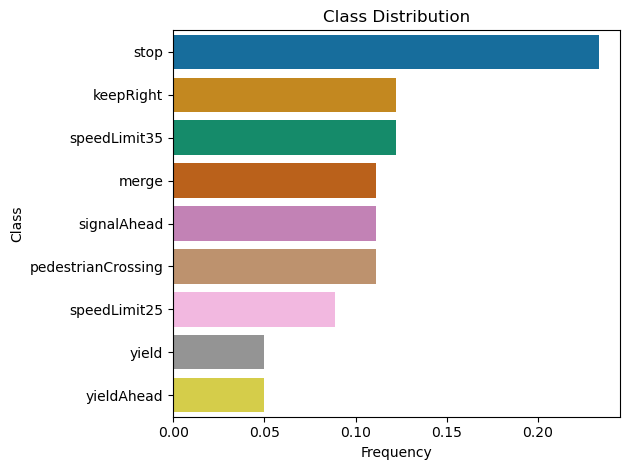

In [31]:
class_distribution = annotations_df['class'].value_counts(normalize=True).reset_index()
class_distribution.columns = ['Class', 'Frequency']

sns.barplot(x='Frequency', y='Class', data=class_distribution, palette="colorblind")

plt.title('Class Distribution')
plt.xlabel('Frequency')
plt.ylabel('Class')

plt.tight_layout()
plt.savefig('../images/presentation/class_dist.png')
plt.show()

In [32]:
def split_dataset(images: np.ndarray, class_labels: np.ndarray) -> Tuple[np.ndarray, ...]:
    """
    Split the dataset into training, validation, and testing sets.

    Args:
        images (np.ndarray): Numpy array of image data.
        class_labels (np.ndarray): Numpy array of class labels.

    Returns:
        Tuple[np.ndarray, ...]: Tuple of numpy arrays for training, validation, and testing sets.
    """
    X_train, X_holdout, y_train, y_holdout = train_test_split(images, class_labels, test_size=0.2, random_state=RANDOM_STATE)
    X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=RANDOM_STATE)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [33]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(images, class_labels)

In [34]:
np.save('../data/preproc_data/X_train.npy', X_train)
np.save('../data/preproc_data/X_val.npy', X_val)
np.save('../data/preproc_data/X_test.npy', X_test)
np.save('../data/preproc_data/y_train.npy', y_train)
np.save('../data/preproc_data/y_val.npy', y_val)
np.save('../data/preproc_data/y_test.npy', y_test)

In [35]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))

Training set size: 2160
Validation set size: 270
Testing set size: 270
